# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Setup

In [198]:
CALIBRATION_IMAGE_FOLDER = 'camera_cal/'
TEST_IMAGE_FOLDER = 'test_images/'
TEST_IMAGE = TEST_IMAGE_FOLDER + 'test1.jpg'

THRESHOLD_RANGE = (140, 255)

## Utilities

In [200]:
import os

def get_test_image():
    return cv2.imread(TEST_IMAGE)

def get_all_test_images():
    return TEST_IMAGE_FOLDER, os.listdir(TEST_IMAGE_FOLDER)
    
def display_single_channel_image(img, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### 1.1 Computation of camera calibration matrix and distortion coefficients.

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_distortion_vars():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(CALIBRATION_IMAGE_FOLDER + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

def undistort(img):
    ret, mtx, dist, rvecs, tvecs = get_distortion_vars()
    return cv2.undistort(img, mtx, dist, None, mtx)

### 1.2. Test for image distortion correction on chessboard image

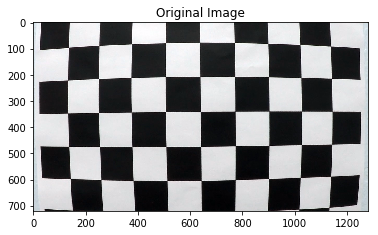

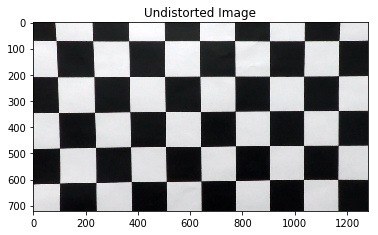

In [4]:
img = cv2.imread(CALIBRATION_IMAGE_FOLDER + 'calibration1.jpg')

plt.title('Original Image')
plt.imshow(img)

plt.figure()
plt.title('Undistorted Image')
undistorted = undistort(img)
plt.imshow(undistorted)

## 2. Apply distortion correction to raw images.

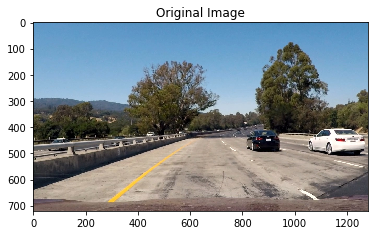

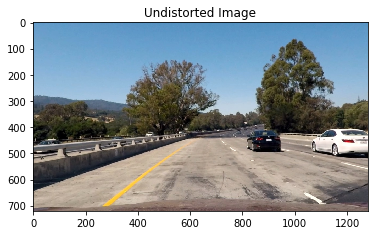

In [5]:
original = get_test_image()
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.title('Original Image')
plt.imshow(rgb)

plt.figure()
plt.title('Undistorted Image')
undistorted = undistort(rgb)
plt.imshow(undistorted)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### 3.1 HLS and Color Thresholds

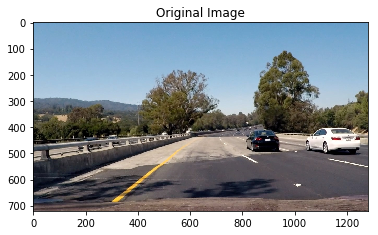

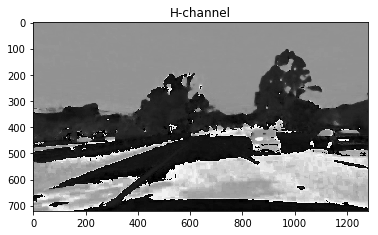

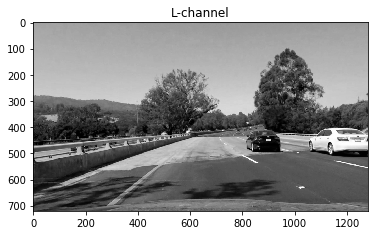

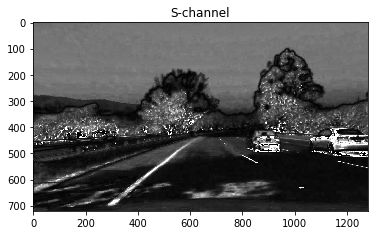

In [199]:
def display_hls_channel_images(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    plt.figure()
    rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    plt.title('Original Image')
    plt.imshow(rgb)

    display_single_channel_image(H, 'H-channel')
    display_single_channel_image(L, 'L-channel')
    display_single_channel_image(S, 'S-channel')
    
original = cv2.imread(TEST_IMAGE)
undistorted = undistort(original)
display_hls_channel_images(undistorted)

In [17]:
def threshold_image(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

### 3.2 Example of thresholded image

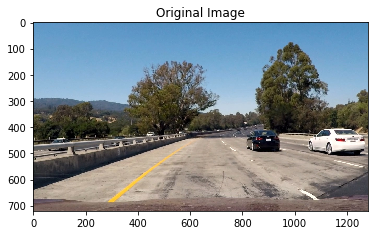

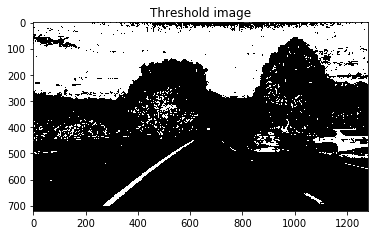

In [174]:
original = get_test_image()
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.title('Original Image')
plt.imshow(rgb)

undistorted = undistort(original)
threshold = threshold_image(undistorted, THRESHOLD_RANGE)
display_single_channel_image(threshold, 'Threshold image')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [184]:
def endpoints_for_perspective_transform():
    return np.array([[[610, 432], [680, 432], [1279, 719], [0, 719]]], dtype=np.int32)

def road_mask(img):
    # end points hard coded for this use case
    pts = endpoints_for_perspective_transform()
    mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.fillPoly(mask, pts, color=(0, 80, 0))
    return mask

def warp(img, pts):
    warped = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    height, width = img.shape[0], img.shape[1]
    src = pts[0].astype('float32')
    dst = np.int32([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]]).astype('float32')
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return warped, M

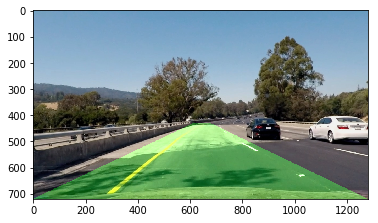

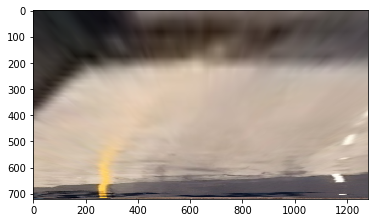

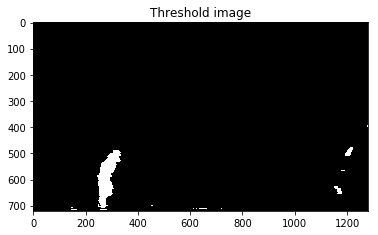

In [201]:
def warp_and_threshold(img):
    undistorted = undistort(img)
    rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

    mask = road_mask(rgb)
    overlay = weighted_img(mask, rgb, 0.95, 1., 0)
    plt.figure()
    plt.imshow(overlay)

    pts = endpoints_for_perspective_transform()
    warped, M = warp(rgb, pts)
    plt.figure()
    plt.imshow(warped)

    threshold = threshold_image(warped, THRESHOLD_RANGE)
    display_single_channel_image(threshold, 'Threshold image')

im = get_test_image()
warp_and_threshold(im)